# Initialization

In [3]:
import os 

%load_ext autoreload
%autoreload 2

os.chdir("/Users/antoineluciano/Documents/Recherche/permABC_new/permABC")


from vanilla import abc_vanilla, perm_abc_vanilla
from smc import abc_smc, perm_abc_smc
from over_sampling import perm_abc_smc_os
from under_matching import perm_abc_smc_um  
from kernels import KernelTruncatedRW
from distances import optimal_index_distance
from models.Gaussian_with_correlated_params import GaussianWithCorrelatedParams
from utils import Theta
from jax import random
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
key = random.PRNGKey(0)
key, key_theta, key_yobs = random.split(key, 3)
K = 10
n_obs = 20
sigma_mu, sigma_alpha = 10., 10.
model = GaussianWithCorrelatedParams(K = K, n_obs = n_obs, sigma_mu = sigma_mu, sigma_alpha = sigma_alpha)
true_theta = model.prior_generator(key_theta, 1)
true_theta.loc[0,0,0] = 0.
true_theta.glob[0,0] = 0.
y_obs = model.data_generator(key_yobs, true_theta)
print("True theta: ", true_theta)

True theta:  Theta(loc=array([[[  0.       ],
        [ 21.891056 ],
        [ -1.6292391],
        [ -0.574461 ],
        [  4.99312  ],
        [  1.0972358],
        [-16.793629 ],
        [ -6.226515 ],
        [ -2.968302 ],
        [  7.779063 ]]], dtype=float32), glob=array([[0.]], dtype=float32))


# Vanilla 

## permABC

In [5]:
key, subkey = random.split(key)
N_points = 100000
zs_perm, thetas_perm, dists_perm, n_sim_perm = perm_abc_vanilla(key = subkey, model = model, n_points = N_points, epsilon = jnp.inf, y_obs = y_obs)
epsilon = np.quantile(dists_perm, 0.01)
index = np.where(dists_perm < epsilon)[0]
mus_perm_van = thetas_perm.loc[index].squeeze()
betas_perm_van = thetas_perm.glob[index].squeeze()
print(epsilon)

N = 1000

Performing full optimal assignment (no prior indices).
11.692900009155274


## ABC

In [ ]:
key, subkey = random.split(key)
zs_van, thetas_van, dists_van, n_sim_van = abc_vanilla(key = subkey, model = model, n_points = N, epsilon = epsilon, y_obs = y_obs)
mus_van = thetas_van.loc.squeeze()
betas_van = thetas_van.glob.squeeze()


# SMC

## ABC

In [31]:
kernel = KernelTruncatedRW 
key, subkey = random.split(key)
# epsilon = 0.
# N = 1000
out_smc = abc_smc(key = subkey, model = model, n_particles= N, epsilon_target= 0, y_obs = y_obs, kernel = kernel, verbose =2, N_sim_max= N*M*K, stopping_accept_rate= 0.)

mus_smc = out_smc['Thetas'][-1].loc.squeeze()
betas_smc = out_smc['Thetas'][-1].glob.squeeze()
n_sim_smc = np.sum(out_smc["N_sim"])

Weights distance: min = 0.0936, max = 0.107
Iteration 0: Epsilon = inf, ESS = 1000 Acc. rate = 100% Numb. unique particles = 1000
1. Forward kernel: 
Sample proposal: loc min = -6.6e+01 max 6.4e+01 mean = -0.11 glob min = -4.2e+01 max = 5.5e+01 mean = 0.16
2. MH acceptance: ratio min = 0.0 max = 1.0 mean 0.034
Prior ratio: min = -42.1, max = 4.08, mean = -11.0
Kernel ratio: min = 0.0, max = 0.0, mean = 0.0
3. Results: Acceptance = 3.58% Rejection ABC = 38.84% Rejection MH = 57.58%
Iteration 1: Espilon = 1321.0296, ESS = 950 Acc. rate = 3.58% Uniqueness rate particules = 100.0% Uniqueness rate components = 100.0% Global parameters uniqueness rate = 100.0%
f) Update weights distance: Weights distance: min = 0.0947, max = 0.106
After update weights update: 950 particles alive (0 particles killed)
NUMBER OF SIMULATIONS 19500/1000000

1. Forward kernel: 
Sample proposal: loc min = -7.7e+01 max 6.8e+01 mean = 0.17 glob min = -4.5e+01 max = 4.8e+01 mean = 1.4
2. MH acceptance: ratio min = 0.0

In [4]:
key, key_theta, key_sim = random.split(key, 3)
thetas = model.prior_generator(key_theta, N)
key, key_sim = random.split(key, 2)
zs = model.data_generator(key_sim, thetas)
dists = model.distance(zs, y_obs)
dists_perm, _, _, _= optimal_index_distance(model, zs, y_obs, 0)
print("ABC dist: min = {}, max = {}, mean = {}".format(np.min(dists), np.max(dists), np.mean(dists)))
print("Perm dist: min = {}, max = {}, mean = {}".format(np.min(dists_perm), np.max(dists_perm), np.mean(dists_perm)))


(10,)
SHapes: y = (10, 100), z = (10, 100), w = (10,), L = 10
ABC dist: min = 262.0743408203125, max = 4554.1357421875, mean = 1522.1527099609375
Perm dist: min = 16.749174118041992, max = 1314.7113037109375, mean = 266.2978820800781


## perm

In [ ]:
N 

In [ ]:
key, subkey = random.split(key)
kernel = KernelTruncatedRW
N = 1000
out_perm_smc = perm_abc_smc(key = subkey, model = model, n_particles= N, epsilon_target= 0, y_obs = y_obs, kernel = kernel, verbose = 2, update_weights_distance=False, Final_iteration=20)
x
mus_perm_smc = out_perm_smc["Thetas"][-1].loc.squeeze()
betas_perm_smc = out_perm_smc["Thetas"][-1].glob.squeeze()
n_sim_perm_smc = np.sum(out_perm_smc["N_sim"])

Weights distance: min = 0.0939, max = 0.105
Performing full optimal assignment (no prior indices).
Weights distance: min = 0.0847, max = 0.127
Iteration 0: Epsilon = inf, ESS = 1000 Acc. rate = 100% Numb. unique particles = 1000
a) Update Epsilon: new epsilon = 9.17e+02
b) Update weights: Old ESS = 1000 New ESS = 950 (5.00% of particles killed)
c) Resampling: No resampling
d) Move particles: 1. Forward kernel: 
Performing full optimal assignment (no prior indices).
Sample proposal: loc min = -5.5e+01 max 5.3e+01 mean = -0.068 glob min = -5.6e+01 max = 5.3e+01 mean = 0.5
2. MH acceptance: ratio min = 0.0 max = 1.0 mean 0.261
Prior ratio: min = -20.8, max = 5.01, mean = -2.9
Kernel ratio: min = -5.17, max = 3.73, mean = -0.0565
3. Results: Acceptance = 26.63% Rejection ABC = 16.63% Rejection MH = 56.74%
Iteration 2: Espilon = 916.5930, ESS = 950 Acc. rate = 26.63% Uniqueness rate particules = 100.0% Uniqueness rate components = 100.0% Global parameters uniqueness rate = 100.0%

a) Update

In [37]:
key, subkey = random.split(key)
kernel = KernelTruncatedRW
N = 1000
model.reset_weights_distance()
out_perm_smc2 = perm_abc_smc(key = subkey, model = model, n_particles= N, epsilon_target= 0, y_obs = y_obs, kernel = kernel, verbose = 2, update_weights_distance=True, Final_iteration=20)

mus_perm_smc2 = out_perm_smc2["Thetas"][-1].loc.squeeze()
betas_perm_smc2 = out_perm_smc2["Thetas"][-1].glob.squeeze()
n_sim_perm_smc2 = np.sum(out_perm_smc2["N_sim"])

Weights distance: min = 0.0957, max = 0.106
Performing full optimal assignment (no prior indices).
Weights distance: min = 0.0892, max = 0.135
Iteration 0: Epsilon = inf, ESS = 1000 Acc. rate = 100% Numb. unique particles = 1000
a) Update Epsilon: new epsilon = 9.83e+02
b) Update weights: Old ESS = 1000 New ESS = 950 (5.00% of particles killed)
c) Resampling: No resampling
d) Move particles: 1. Forward kernel: 
Performing full optimal assignment (no prior indices).
Sample proposal: loc min = -4.7e+01 max 4.8e+01 mean = 0.014 glob min = -5e+01 max = 5e+01 mean = 0.15
2. MH acceptance: ratio min = 0.0 max = 1.0 mean 0.253
Prior ratio: min = -16.9, max = 8.03, mean = -2.94
Kernel ratio: min = -4.37, max = 2.87, mean = -0.00308
3. Results: Acceptance = 25.26% Rejection ABC = 17.26% Rejection MH = 57.47%
e) Update weights distance: Weights distance: min = 0.0833, max = 0.143
Performing full optimal assignment (no prior indices).
After update weights update: 950 particles alive (0 particles 

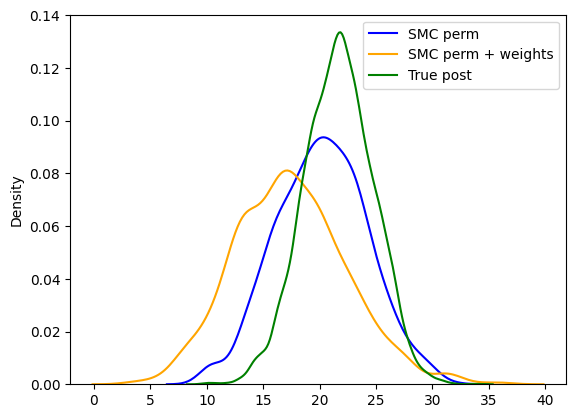

In [40]:
k = 1
sns.kdeplot(mus_perm_smc[:,k], label="SMC perm", color="blue")
sns.kdeplot(mus_perm_smc2[:,k], label="SMC perm + weights", color="orange")
sns.kdeplot(true_post_mu[:,k], label="True post", color="green")
plt.legend()
plt.show()


## Over Sampling

In [6]:
M0 = 50
key = random.PRNGKey(0)
key, subkey = random.split(key)
kernel = KernelTruncatedRW
os = perm_abc_smc_os(key = subkey, model = model, n_particles= N, epsilon = epsilon, y_obs = y_obs, kernel = kernel, verbose = 3, M_0 = M0, duplicate= True, n_duplicate = 0, alpha_M = .9, Final_iteration= 50, update_weights_distance= False)
mus_os = os["Thetas"][-1].loc.squeeze()
betas_os = os["Thetas"][-1].glob.squeeze()
n_sim_os = np.sum(os["N_sim"])

a) Simulation of the first particles:
b) Computing the first distances: (10,)
SHapes: y = (10, 100), z = (50, 100), w = (10,), L = 10
Performing full optimal assignment (no prior indices).
min = 0.69 max = 1.5e+02 mean = 7.4
d) Setting the first weights: ESS = 971
Iteration 0: M = 50 Epsilon = 29.23336061477661, ESS = 971 Acc. rate = 100% Numb. unique particles = 1000

a) Update M: new M = 46 old M = 50
b) Duplicate particles
Adaptive duplication: n_duplicate =  2
Duplicating the 971 alive particles in 2 copies...
(1942, 50) 2
Now particles of shape (2942, 50, 1) and (2942, 50, 100) with 2942 unique particles
c) Truncate particles: before (2942, 50, 1),(2942, 50, 100) after (2942, 46, 1),(2942, 46, 100)
Aucun changement =  False
d) Compute optimal distances: 971 unique alive particles (10,)
SHapes: y = (10, 100), z = (46, 100), w = (10,), L = 10
Performing full optimal assignment (no prior indices).
e) Weights update/Killing of the particles: Old ESS = 2913 New ESS = 2902 (0.38% of the

## Under Matching 

In [11]:
L0 = 3
key = random.PRNGKey(0)
key, subkey = random.split(key)
kernel = KernelTruncatedRW
um = perm_abc_smc_um(key = subkey, model = model, n_particles= N, epsilon = epsilon, y_obs = y_obs, kernel = kernel, verbose = 3, L_0 = L0,  alpha_L = .75, alpha_epsilon= .75,Final_iteration= 50)

mus_um = um["Thetas"][-1].loc.squeeze()
betas_um = um["Thetas"][-1].glob.squeeze()
n_sim_um = np.sum(um["N_sim"])

AttributeError: 'Model' object has no attribute 'reset_weights_distance'

### Comparison

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

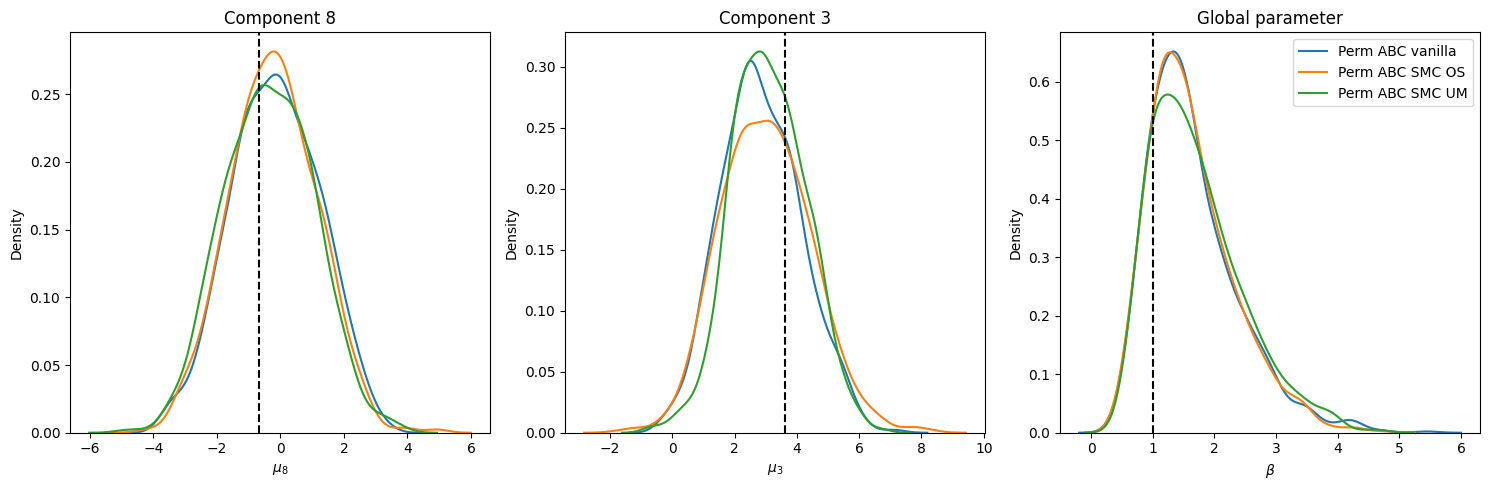

In [16]:
N_plot = 2

f, ax = plt.subplots(1, N_plot + 1, figsize=(15, 5))
if N_plot < K:
    perm = np.random.permutation(K)
else:
    perm = np.arange(K)

for i in range(N_plot):
    k = perm[i]
    sns.kdeplot(np.unique(mus_perm_van[:, k]), ax=ax[i], label="Perm ABC vanilla")
    # sns.kdeplot(np.unique(mus_van[:, k]), ax=ax[i], label="ABC vanilla")
    # sns.kdeplot(np.unique(mus_smc[:, k]), ax=ax[i], label="ABC SMC")
    # sns.kdeplot(np.unique(mus_perm_smc[:, k]), ax=ax[i], label="Perm ABC SMC")
    sns.kdeplot(np.unique(mus_os[:, k]), ax=ax[i], label="Perm ABC SMC OS")
    sns.kdeplot(np.unique(mus_um[:, k]), ax=ax[i], label="Perm ABC SMC UM")
    ax[i].axvline(true_theta.loc[0, k], color="black", linestyle="--")
    ax[i].set_title("Component {}".format(k))
    # ax[i].legend()
    ax[i].set_xlabel(r"$\mu_{}$".format(k))
    ax[i].set_ylabel("Density")

sns.kdeplot(np.unique(betas_perm_van), ax=ax[-1], label="Perm ABC vanilla")
# sns.kdeplot(np.unique(betas_van), ax=ax[-1], label="ABC vanilla")
# sns.kdeplot(np.unique(betas_smc), ax=ax[-1], label="ABC SMC", fill=True)
# sns.kdeplot(np.unique(betas_perm_smc), ax=ax[-1], label="Perm ABC SMC")
sns.kdeplot(np.unique(betas_os), ax=ax[-1], label="Perm ABC SMC OS")
sns.kdeplot(np.unique(betas_um), ax=ax[-1], label="Perm ABC SMC UM")
ax[-1].axvline(true_theta.glob[0], color="black", linestyle="--")
ax[-1].set_title("Global parameter")
ax[-1].legend()
ax[-1].set_xlabel(r"$\beta$")
ax[-1].set_ylabel("Density")
plt.tight_layout()
plt.show()

# ABC-Gibbs

In [26]:
import numpy as np
from tqdm.notebook import tqdm
from jax import vmap, jit, random
import jax.numpy as jnp
from scipy import stats
from scipy.optimize import linear_sum_assignment

@jit
def distance_one_silo(x_k,y_k):
    return jnp.sum((x_k-y_k)**2)

@jit
def distance_all_silo(x,y):
    return vmap(distance_one_silo, in_axes=(0, 0))(x,y)
@jit
def distance_xs(xs, y):
    return vmap(distance_all_silo, in_axes=(0, None))(xs, y)

@jit
def distance_sum_silo(x,y):
    return jnp.mean((distance_all_silo(x,y)))

@jit
def distance_sum(xs, y):
    return (vmap(distance_sum_silo, in_axes=(0, None))(xs, y))
# @jit 
# def dist_full_y(xs, y):
#     return jnp.sum(vmap(dist_full, in_axes=(0, None))(xs, y), axis = 1)

def ABCmus(key, M, y_obs, alpha):
    key, key_mus, key_data = random.split(key, 3)
    mus = random.normal(key_mus, shape=(M,K))*model.sigma_mu
    thetas = Theta(loc = mus[:,:,None], glob = np.repeat([alpha], M)[:,None])
    xs = model.data_generator(key_data, thetas)
    dists = distance_xs(xs, y_obs)
    index_min = jnp.argmin(dists, axis=0)
    Eps_betas = jnp.array([dists[index_min[i],i] for i in range(K)])
    mus_min = np.array([mus[index_min[i],i] for i in range(K)])
    return mus_min, Eps_betas
    

def ABCalpha(key, M, y_obs, mus):
    key, key_alpha, key_data = random.split(key, 3)
    alphas = random.normal(key_alpha, shape=(M,1))*model.sigma_alpha
    thetas = Theta(loc = np.repeat([mus], M, axis=0)[:,:,None], glob = alphas)
    xs = model.data_generator(key_data, thetas)
    dists = distance_sum(xs, y_obs)
    index_min = jnp.argmin(dists)
    Eps_alpha = dists[index_min]
    alpha_min = alphas[index_min]
    return alpha_min[0], Eps_alpha



def gibbs_robin(key, T, M_mu, M_alpha, y_obs):
    mus = np.zeros((T+1,K))
    alphas = np.zeros(T+1)
    
    Eps_mu = np.zeros((T, K))
    Eps_alpha = np.zeros(T)
    
    
    key, key_alpha, key_mu = random.split(key, 3)
    
    # alphas[0] = -10
    mus[0] = random.normal(key_mu, shape=(K,))*model.sigma_mu
    # mus[0] = -10
    alphas[0] = random.normal(key_alpha)*model.sigma_alpha
    for t in tqdm(range(T)):
        key, key_mus = random.split(key)
        mus[t+1], Eps_mu[t] = ABCmus(key_mus, M_mu, y_obs, alphas[t])
        key, key_alpha = random.split(key)
        alphas[t+1], Eps_alpha[t] = ABCalpha(key_alpha, M_alpha, y_obs, mus[t+1])
        
    return mus, alphas, Eps_mu, Eps_alpha 

In [ ]:
# M = int(n_sim_perm_smc/((N)*2*K))
# print(model.sigma_alpha, model.sigma_mu, model.K, model.n_obs)
# print(y_obs[0].shape)
N = 1000
M = n_sim_perm_smc//(2*K*N)
print(M)
mus_gibbs, alphas_gibbs, Eps_mus_gibbs, Eps_alphas_gibbs = gibbs_robin(key, N, M, M, y_obs[0])

51


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(
/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(


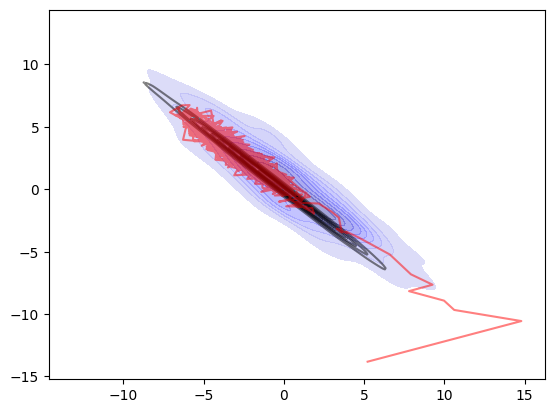

In [ ]:
k = 0
sns.kdeplot(x=true_post_mu[:, k], y=true_post_alpha, label="True posterior", level = 3, color = "black", alpha = .5)
sns.kdeplot(x = mus_perm_smc[:,k], y = betas_perm_smc, label = "Perm ABC SMC", level = 3, color = "blue", alpha = .5, fill=True)

# sns.kdeplot(x = mus_gibbs[:,k], y = alphas_gibbs, label = "Gibbs", level = 3, color = "red", alpha = .5, fill=True)
plt.plot(mus_gibbs[:,k], alphas_gibbs, color = "red", alpha = .5)

/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(


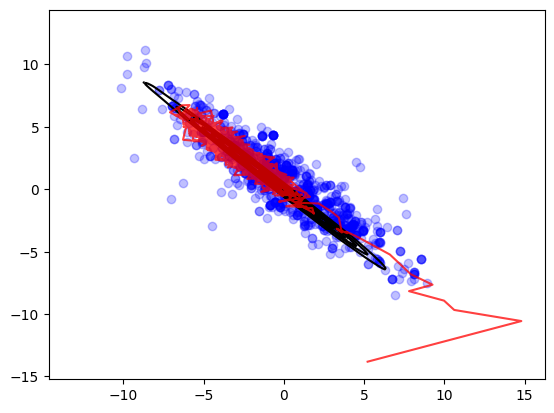

In [49]:
k = 0
plt.scatter(x = mus_perm_smc[:,k], y = betas_perm_smc, label = "Perm ABC SMC", color = "blue", alpha = .25)

# sns.kdeplot(x = mus_gibbs[:,k], y = alphas_gibbs, label = "Gibbs", level = 3, color = "red", alpha = .5, fill=True)
sns.kdeplot(x=true_post_mu[:, k], y=true_post_alpha, label="True posterior", level = 3, color = "black", alpha =1 )

plt.plot(mus_gibbs[:,k], alphas_gibbs, color = "red", alpha = .75)
# sns.kdeplot(x=true_post_mu[:, k], y=true_post_alpha, label="True posterior", level = 3, color = "black", alpha =1 )


# PyMC 

In [ ]:
import pymc as pm

# Define the model
with pm.Model() as mod:
    # Priors for unknown model parameters

    sigma_x = 1.0

    mu = pm.Normal('mu', mu=0, sigma=sigma_mu, shape=(K, 1))
    alpha = pm.Normal('alpha', mu=0, sigma=sigma_alpha, shape=(1, 1))

    # Likelihood (sampling distribution) of observations
    x = pm.Normal('x', mu=mu + alpha, sigma=sigma_x, observed=y_obs[0])

    # Inference
    trace = pm.sample(N_pymc, return_inferencedata=True)


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha]
/Users/antoineluciano/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/antoineluciano/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.


In [ ]:
true_post_mu = np.array(trace.posterior.mu[:,:,:,0]).reshape(4*N_pymc, K)
true_post_alpha = np.array(trace.posterior.alpha).reshape(-1)

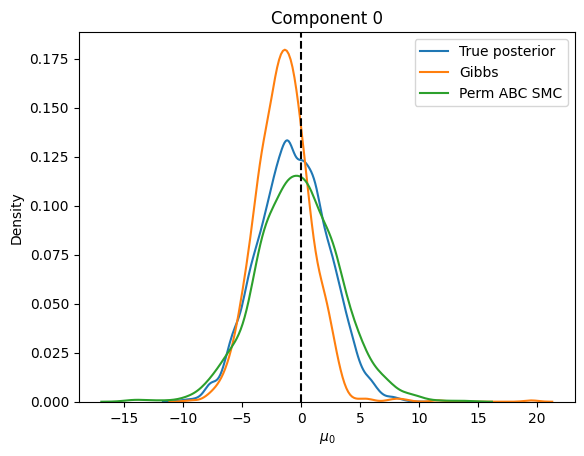

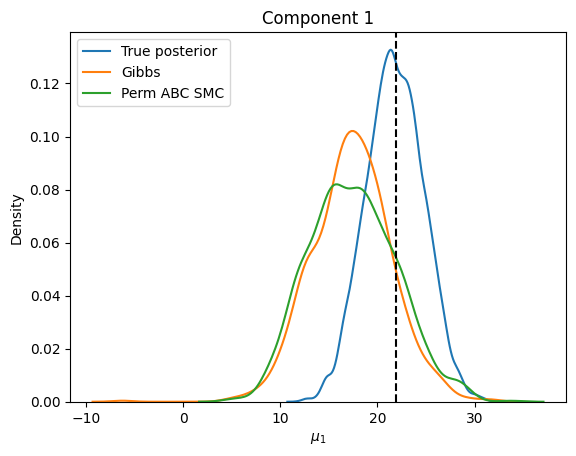

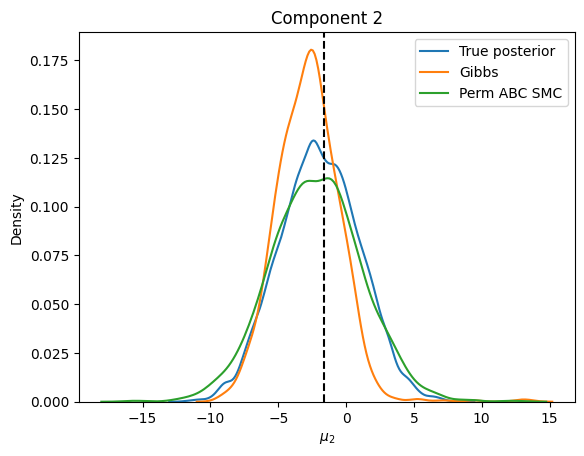

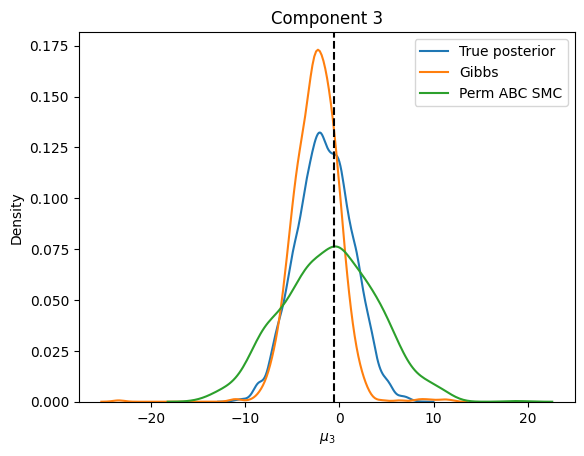

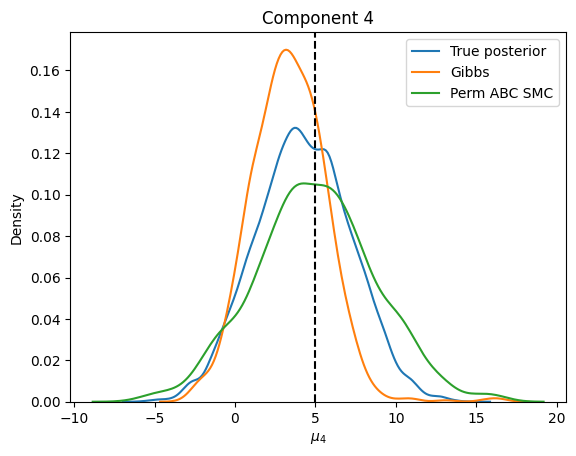

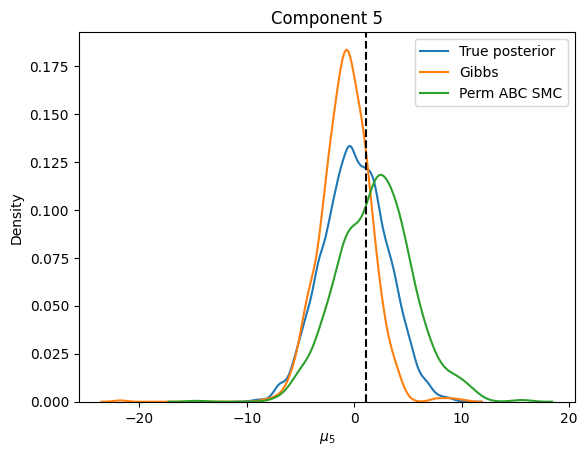

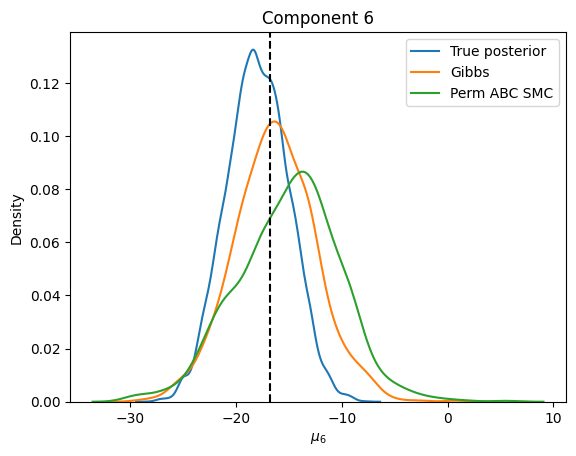

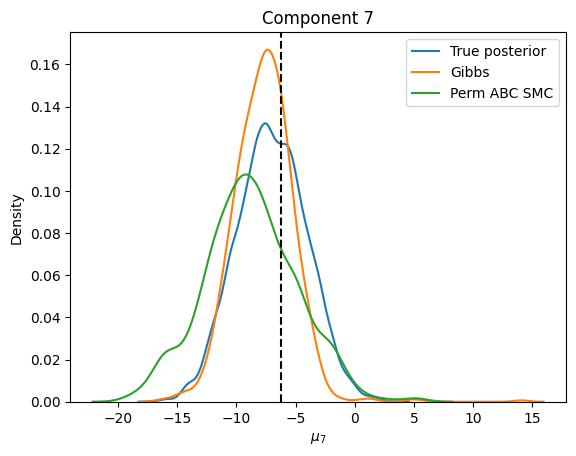

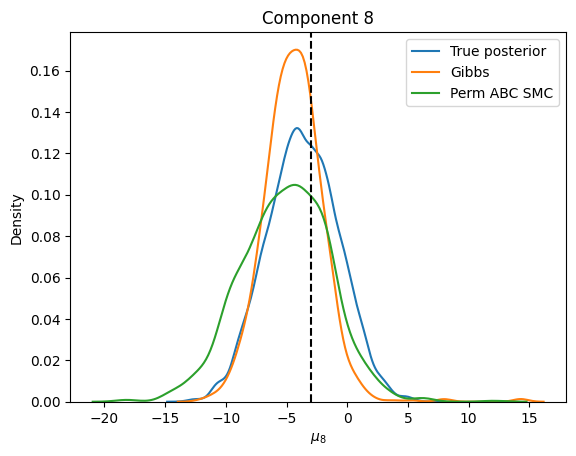

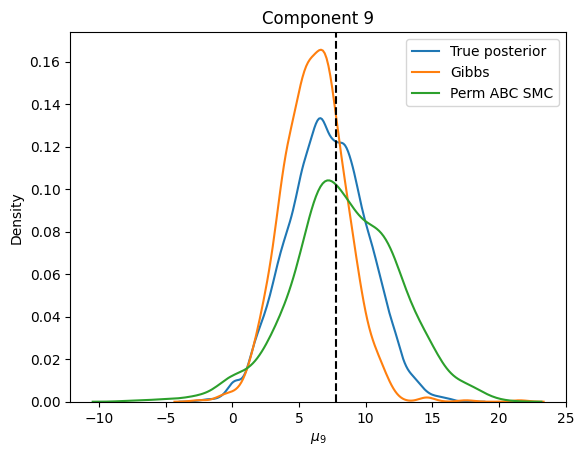

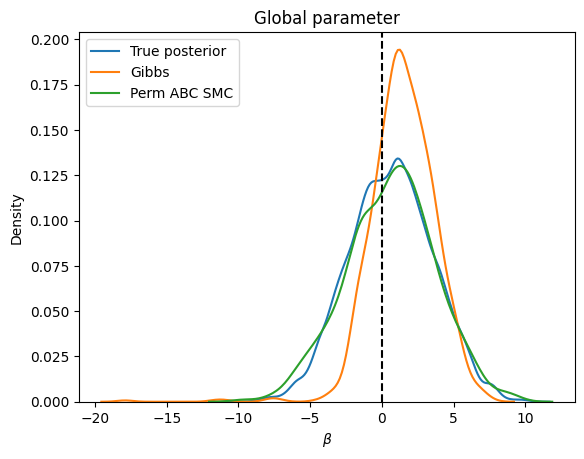

In [39]:
for k in range(K):
    sns.kdeplot(true_post_mu[:,k], label="True posterior")
    sns.kdeplot(mus_gibbs[:,k], label="Gibbs")
    sns.kdeplot(mus_perm_smc[:,k], label="Perm ABC SMC")
    plt.axvline(true_theta.loc[0,k], color="black", linestyle="--")
    plt.title("Component {}".format(k))
    plt.xlabel(r"$\mu_{}$".format(k))
    plt.ylabel("Density")
    plt.legend()
    plt.show()
plt.show()
sns.kdeplot(true_post_alpha, label="True posterior")
sns.kdeplot(alphas_gibbs, label="Gibbs")
sns.kdeplot(betas_perm_smc, label="Perm ABC SMC")
plt.axvline(true_theta.glob[0], color="black", linestyle="--")
plt.title("Global parameter")
plt.xlabel(r"$\beta$")
plt.ylabel("Density")
plt.legend()

plt.show()

Probleme permSMC ? Acc plus faible que OS et UM pour meme epsilon!!!

# PLOT

In [42]:
n_sim_perm_smc

1024910

/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(
/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(


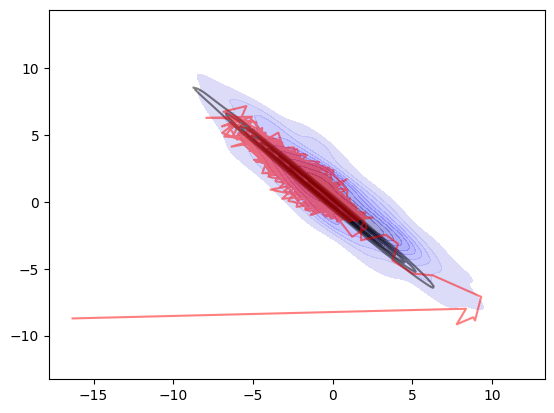

In [41]:
k = 0
sns.kdeplot(x=true_post_mu[:, k], y=true_post_alpha, label="True posterior", level = 3, color = "black", alpha = .5)
sns.kdeplot(x = mus_perm_smc[:,k], y = betas_perm_smc, label = "Perm ABC SMC", level = 3, color = "blue", alpha = .5, fill=True)
# sns.kdeplot(x = mus_gibbs[:,k], y = alphas_gibbs, label = "Gibbs", level = 3, color = "red", alpha = .5, fill=True)
plt.plot(mus_gibbs[:,k], alphas_gibbs, color = "red", alpha = .5)

# plt.scatter(mus_perm_smc[:,k], betas_perm_smc, alpha = .1, color = "blue", label = "Perm ABC SMC")
# plt.scatter(mus_gibbs[:,k], alphas_gibbs, alpha = .1, color = "red", label = "Gibbs")
# sns.kdeplot(x=true_post_mu[:, k], y=true_post_alpha, label="True posterior", level = 3, color = "black")



# plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


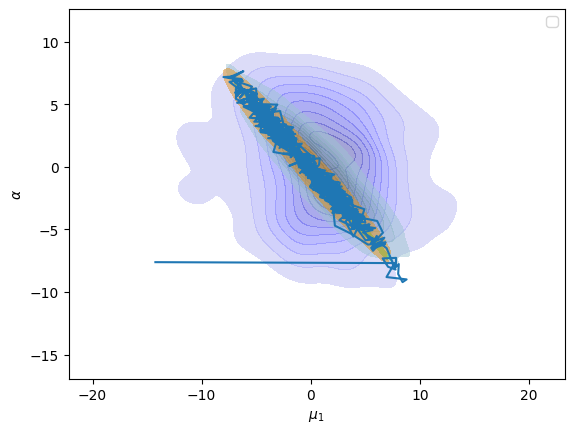

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.kdeplot(x = mus_van[:, 0], y = betas_van.squeeze(), label='ABC Vanille', color = "pink", alpha = .5, fill = True)
k = 0
sns.kdeplot(x = mus_perm_smc[:, 0], y = betas_perm_smc, label='ABC SMC perm',  color = "darkblue", alpha =.5, fill = True)
# sns.kdeplot(x = mus_perm_van[:, 0], y = betas_perm_van.squeeze(), label='ABC Vanille perm', color = "lightblue", alpha = .5, fill = True)
sns.kdeplot(x = true_post_mu_k, y = true_post_alpha, label = "True", color = "green", alpha = .5, levels=3, fill = True)

# sns.kdeplot(x = mus_smc[:, k], y = alphas_smc, label='ABC SMC')
sns.kdeplot(x = np.array(mus_gibbs[:,0]), y = np.array(alphas_gibbs), label='ABC Gibbs', color ="orange", levels=3, fill = True, alpha = .5)
# plt.scatter(true_theta.loc[0,k], true_theta.glob[0], color='red', label='True value', marker = "x")
plt.ylabel("$\\alpha$")
plt.xlabel('$\mu_{'+str(1)+'}$')
plt.legend()


In [10]:
a

NameError: name 'a' is not defined